In [1]:
import os
import sys
import warnings
import tqdm


import numpy as np
import scipy

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.cm import get_cmap

import mplcyberpunk
plt.style.use('cyberpunk')

warnings.filterwarnings('ignore')

In [2]:
class CylinderFlow(object):

    def __init__(self,
                 Nx : int = 500,
                 Ny : int = 250,
                 N_steps : int  = 15000,
                 save_freq : int = 20,
                 tau : float = 0.65,
                 u_inlet : float = 0.12,
                 i_inlet : float = 0.,
                 u_x : float = 0.12,
                 u_y : float = 0.):

        r"""
        Задаем физические параметры модели:
            - Nx, Ny - размерность сетки
            - N_steps - кол-во шагов
            - tau - параметр вязкости
            - u_inlet, i_inlet - параметр набегающего потока
            - геометрия цилинда
        """

        self.Nx = Nx
        self.Ny = Ny
        self.N_steps = N_steps
        self.save_freq = save_freq 
        self.tau = tau

        self.x_cent = Nx//5
        self.y_cent = Ny//2
        self.radius = Ny//8
        self.X, self.Y = np.meshgrid(np.arange(Nx), np.arange(Ny), indexing = 'ij')
        self.cylinder = (self.X-self.x_cent)**2 + (self.Y-self.y_cent)**2 <= self.radius**2


        self.u_inlet = 0.12
        self.i_inlet = 0
        self.u_x = u_inlet
        self.u_y = 0.0

        self.verbose = True
        self.download_gif = True



    def save_GIF(self, array_list, output_file='Vorticity_Rodionov_626.gif', interval=200, cmap_ = 'jet'):

        r"""
        Функция для сохранения анимации
        """
    
        fig, ax = plt.subplots()
    
        im = ax.imshow(array_list[0], animated=True, cmap=cmap_)
        cbar = fig.colorbar(im, ax=ax)
    
        def update(frame):
            im.set_array(frame)
            im.set_clim(vmin=np.quantile(frame, 0.01), vmax=np.quantile(frame, 0.99))
            cbar.update_normal(im)
            return [im]
    
        ani = FuncAnimation(
            fig, update, frames=array_list, interval=interval, blit=False
        )
    
        ani.save(output_file, writer='pillow')

        plt.close(fig)

    def compute_flow(self):
        w   = np.array([4/9] + [1/9]*4 + [1/36]*4)          # параметры модели D2Q9 (как декартова произведения D1Q3)
        u   = np.zeros((2, self.Nx, self.Ny))                         # Поле скоростей
        f   = np.zeros((9, self.Nx, self.Ny))                         # Распределение плотности потока
        rho = np.ones((self.Nx, self.Ny))                         
        e   = np.array([[0,0],                             #Векторы, задающие направление потока
                        [1,0],[0,1], [-1,0], [0,-1],
                        [1,1],[-1,1],[-1,-1],[1,-1]])
        opposite = [0, 3, 4, 1, 2, 7, 8, 5, 6]              
        
        # Зададим F из положения равновесия
        f = w[:, np.newaxis, np.newaxis] * rho[np.newaxis, :, :]
        
        # Массив для хранения поля скоростей по итерациям
        u_hist = [  ]

        for i_step in tqdm.tqdm(range(self.N_steps)):

            rho  = np.sum(f, axis = 0)
            u[0] = np.sum(f * e[:, 0][:, np.newaxis, np.newaxis], axis = 0) / rho
            u[1] = np.sum(f * e[:, 1][:, np.newaxis, np.newaxis], axis = 0) / rho 
        
        
            # Граничные условия
            u[0, self.i_inlet, :] = self.u_x 
            u[1, self.i_inlet, :] = self.u_y 
        
            rho[self.i_inlet, :] = (1 / (1 - self.u_x)) * (f[0, self.i_inlet, :] + f[2, self.i_inlet, :] + f[4, self.i_inlet, :] +2 * (f[3, self.i_inlet, :] + f[6, self.i_inlet, :] + f[7, self.i_inlet, :]))
        
            f[1, self.i_inlet, :] = f[3, self.i_inlet, :] + (2/3) * rho[self.i_inlet, :] * self.u_x
            f[5, self.i_inlet, :] = f[7, self.i_inlet, :] + (1/6) * rho[self.i_inlet, :] * (self.u_x + self.u_y)
            f[8, self.i_inlet, :] = f[6, self.i_inlet, :] + (1/6) * rho[self.i_inlet, :] * (self.u_x - self.u_y)
        
            u[0] *= (1 - self.cylinder)
            u[1] *= (1 - self.cylinder)
            for i_dir in range(9):
                f[i_dir, self.cylinder] = f[opposite[i_dir], self.cylinder]
        
            self.i_outlet = self.Nx - 1
            f[:, self.i_outlet, :] = f[:, self.i_outlet - 1, :]
        
            f_eq = np.zeros_like(f)
            u_sq = u[0]**2 + u[1]**2
            for i_dir in range(9):
                e_dot_u = e[i_dir,0]*u[0] + e[i_dir,1]*u[1]
                f_eq[i_dir] = w[i_dir]*rho*(1 + 3*e_dot_u + 9/2*e_dot_u**2 - 3/2*u_sq)
        
            f = f - 1/self.tau*(f - f_eq)
        
            for i_dir in range(9):
                f[i_dir] = np.roll(f[i_dir], shift = e[i_dir], axis = (0,1))
            
            f[:, self.i_outlet, :] = f[:, self.i_outlet-1, :]
        
        
            if (i_step % self.save_freq == 0):
                u_hist.append(u.copy())

        u_magnitude = [np.sqrt(u_[0]**2 + u_[1]**2) for u_ in u_hist]
        u_vorticity = [np.gradient(u_[0], 1, axis=0) - np.gradient(u_[1], 1, axis=1) for u_ in u_hist]

        #отрисовка последнего кадра
        if self.verbose: 
            fig, axes = plt.subplots(1,2, figsize = (10, 6))
            pos0 = axes[0].imshow(u_magnitude[-1], cmap = 'winter')
            pos1 = axes[1].imshow(u_vorticity[-1], cmap = 'winter', vmin = np.quantile(u_vorticity[-1], 0.02), vmax = np.quantile(u_vorticity[-1], 0.98))
            
            axes[0].set_title('Поле скоростей', fontsize = 10)
            axes[1].set_title('Завихренность', fontsize = 10)
            
            fig.colorbar(pos0, aspect = 40, shrink = 0.9)
            fig.colorbar(pos1, aspect = 40, shrink = 0.9)
            
            plt.show()

        if self.download_gif:
            self.save_GIF(u_vorticity[::3], interval=45, cmap_ = 'winter', output_file='Vorticity_Rodionov_626.gif')

        
        


            


        
        

In [3]:
CylinderFlow_instance = CylinderFlow()

100%|█████████████████████████████████████| 15000/15000 [07:27<00:00, 33.49it/s]


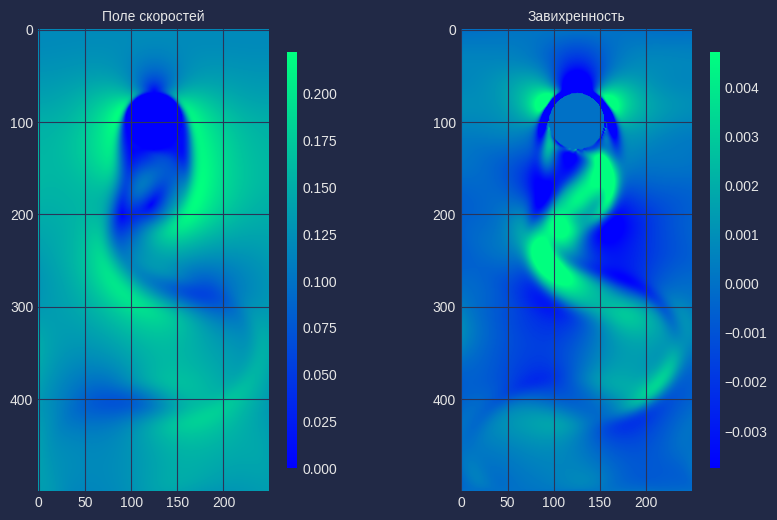

In [4]:
CylinderFlow_instance.compute_flow()